In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim

In [2]:
import functools

CUDA = torch.cuda.is_available()

torch.manual_seed(42)
class CBOW(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        
        if CUDA:
            self.embedding = self.embedding.cuda()
        self.hidden = nn.Linear(embedding_size, vocab_size)
        self.op = nn.LogSoftmax()
        
    def forward(self, X):
        p = self.embedding(X.long())
        q = torch.mean(p, dim=0).view(1,-1)
        r = self.hidden(q)
        s = self.op(r)
        
        return s

In [3]:
def text_to_train(text, context_window):
    '''
    Convert text to data for training cbow model
    '''
    
    data = []
    
    for i in range(context_window, len(text) - context_window):
        context = [
            text[i+e] for e in range(-context_window, context_window+1) if i+e != i
        ]
        target = text[i]
        
        data.append((context, target))
    return data

In [4]:
text = '''As the eight strange beings applauded, one of them even cupping a hand over her lipsticked mouth to cheer, Joel tried to grasp what was happening. The nine of them sat in a fire rimmed cavern around a conference table shaped from warm volcanic rock. A chandelier of human bones dangled from the cavern’s ceiling, and it rattled around at random like wind chimes. A massive goat-man with reddish-black skin and wicked horns on his head towered above the seven others, who flanked him to either side. They looked like pure stereotype. A fat slob with sixteen chins, a used car saleman looking guy with gold and silver jewelry all over him, a sultry dominatrix in skin tight leather. On the other side a disheveled looking college drop out, a pretty boy staring in a mirror, a bald, muscular dude who looked like someone’s pissed off step-dad and a sour faced woman glancing jealously around the room. Just where the hell was he? Joel concentrated on his last memory. He remembered highlighting pages as his private jet, “The Holy Gust,” flew over the sapphire waters of the Bahamas. He had been reviewing his sermon for Sunday – dotting the I’s and crossing the crosses, a little god humor there, praise him – and the pilot’s voice had crackled over the intercom about turbulence. Kimberly, his personal assistant, had taken his plow out of her mouth and put on her seat belt. The plane had shook and then'''.lower().split()

In [5]:
vocab = set(text)
word2index = {w:i for i,w in enumerate(vocab)}
index2word = {i:w for i,w in enumerate(vocab)}


data = text_to_train(text, 2)

In [6]:
def words_to_tensor(words: list, w2i: dict, dtype=torch.FloatTensor):
    tensor =  dtype([
        w2i[word] for word in words
    ])
    
    if CUDA:
        tensor = tensor.cuda()
    return Variable(tensor)

In [7]:
def get_prediction(context, model):
    model.eval()
    prediction = model(words_to_tensor(context, word2index))
    _, index = torch.max(prediction, 1)
    return index2word[index.data[0]]

def check_accuracy(model):
    correct = 0
    for context, target in data:
        prediction = get_prediction(context, model)
        if prediction == target:
            correct += 1
    return correct/len(data)

In [ ]:
## Training

learning_rate = 0.001
epochs = 1000

model = CBOW(len(vocab), 100)

if CUDA:
    model = model.cuda()

loss_func = torch.nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
losses = []

for epoch in range(epochs):
    total_loss = 0
    
    for context, target in data:
        ids = words_to_tensor(context,word2index)
        target = words_to_tensor([target], word2index, dtype=torch.LongTensor)
        
        model.zero_grad()
        output = model(ids)
        
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    if epoch%100 == 0:
        accuracy = check_accuracy(model)
        print("Accuracy after epoch {} is {}".format(epoch, accuracy))
    losses.append(total_loss)

/development/bin/python/conda3_ana/envs/pynlp_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


KeyError: tensor(94)

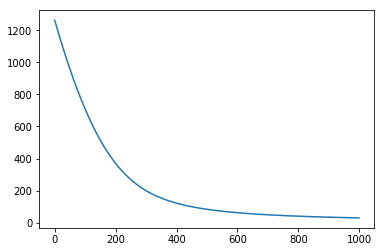

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses)
plt.show()